In [1]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
this_folder = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
this_folder

'/Users/jseverin/Athena/NREL_github/ATHENA-siem-sumo/Sumo/Simulations'

# Generating Demand from flight data model


In [3]:
demand = pd.read_csv('athena_sumo_v1.csv')

In [4]:
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017


In [5]:
def month(string):
    string = string.lower()
    if string.startswith( 'jan' ):
        month = 1
    elif string.startswith( 'feb' ):
        month = 2
    elif string.startswith( 'mar' ):
        month = 3
    elif string.startswith( 'apr' ):
        month = 4
    elif string.startswith( 'may' ):
        month = 5
    elif string.startswith( 'jun' ):
        month = 6
    elif string.startswith( 'jul' ):
        month = 7
    elif string.startswith( 'aug' ):
        month = 8
    elif string.startswith( 'sep' ):
        month = 9
    elif string.startswith( 'oct' ):
        month = 10
    elif string.startswith( 'nov' ):
        month = 11
    elif string.startswith( 'dec' ):
        month = 12
    else:
        print("Sorry – wrong input. Try another month")

    return month
        
def day(string):
    string = string.lower()
    if string.startswith('mon'):
        day = 0
    elif string.startswith('tue'):
        day = 1
    elif string.startswith('wed'):
        day = 2
    elif string.startswith('thu'):
        day = 3
    elif string.startswith('fri'):
        day = 4
    elif string.startswith('sat'):
        day = 5
    elif string.startswith('sun'):
        day = 6
    else:
        print('Sorry – wrong day of week inputed')
    return day

In [6]:
from datetime import datetime
dw = []
for i, row in enumerate(demand['scheduled_fight_time']):
    today = datetime_object = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
    dow = today.weekday() 
    dw.append(dow)
demand['day_of_week'] = dw #adding a column day of week

In [7]:

demand['total_pass'] = demand[['parking','pass','A','B','C','D','E']].sum(axis=1) # aggregating across the terminals

In [8]:
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year,day_of_week,total_pass
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017,6,194.0
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017,6,125.0
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017,6,72.0
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017,6,61.0
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017,6,69.0


In [9]:

date = []
for i, row in enumerate(demand['scheduled_fight_time']):
    date.append(row.split()[0])
demand['date'] = date # adding a date without timestamp column to aggregate over

In [10]:
day_df = demand.groupby('date').sum()
sorted_top10 = day_df.sort_values(['total_pass']).tail(10)
sorted_bott10 = day_df.sort_values(['total_pass']).head(10)
length = round(day_df.shape[0]/2)
median_days = day_df.sort_values(['total_pass'])[(length-5):(length+5)]
sort_all = day_df.sort_values(['total_pass'])

# Top 10 highest Volume days - Aggregated over the day


In [11]:
sorted_top10[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-07-16,14800.0,4597.0,15364,8582,17241,8433,1006,70023.0
2018-06-07,13179.0,6108.0,15694,8652,17223,8198,1059,70113.0
2018-05-21,14632.0,5737.0,15262,8544,17273,8050,1015,70513.0
2018-06-25,15134.0,4901.0,15470,8775,17528,8382,1026,71216.0
2018-07-09,15050.0,4619.0,15654,8644,17640,8648,1032,71287.0
2018-06-18,15485.0,4553.0,15688,8716,17600,8656,1055,71753.0
2018-07-13,11614.0,5080.0,16880,9317,19035,8994,1136,72056.0
2018-06-08,11948.0,5648.0,16888,9476,18658,9202,1147,72967.0
2018-06-11,15339.0,5010.0,16152,9018,18089,8610,1088,73306.0


# Bottom 10 Volume Days

In [12]:
sorted_bott10[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-03-31,5041.0,2981.0,7472,4161,8425,4002,513,32595.0
2018-02-03,5829.0,2927.0,8129,4515,9005,4368,554,35327.0
2018-01-20,5723.0,2864.0,8528,4719,9275,4543,582,36234.0
2018-04-07,5969.0,3001.0,8621,4920,9751,4662,574,37498.0
2018-01-27,5515.0,4752.0,8339,4704,9342,4365,552,37569.0
2017-11-24,4715.0,3200.0,9049,5047,10410,4923,617,37961.0
2017-12-02,6219.0,3532.0,8606,4815,9728,4520,579,37999.0
2017-12-31,5215.0,1675.0,9562,5394,10707,5088,648,38289.0
2017-11-23,6305.0,3086.0,8935,5017,9908,4945,589,38785.0


# Middle 10 days

In [13]:
median_days[['parking','pass','A','B','C','D','E','total_pass']]

,parking,pass,A,B,C,D,E,total_pass
date,,,,,,,,
2018-09-06,12561.0,6160.0,12012,6742,13450,6187,823,57935.0
2018-01-08,12879.0,4360.0,12400,7041,13898,6569,832,57979.0
2018-03-23,9758.0,5825.0,13047,7290,14559,6632,896,58007.0
2018-01-22,13406.0,4964.0,12128,6803,13440,6446,837,58024.0
2018-04-05,10754.0,5423.0,12833,7177,14190,6824,847,58048.0
2018-01-02,8598.0,3619.0,13972,7824,15643,7480,928,58064.0
2017-12-08,10249.0,5780.0,12745,7109,14390,6938,863,58074.0
2017-12-18,11592.0,4646.0,12881,7137,14351,6665,866,58138.0
2018-09-30,7708.0,2876.0,14623,8005,16271,7731,976,58190.0


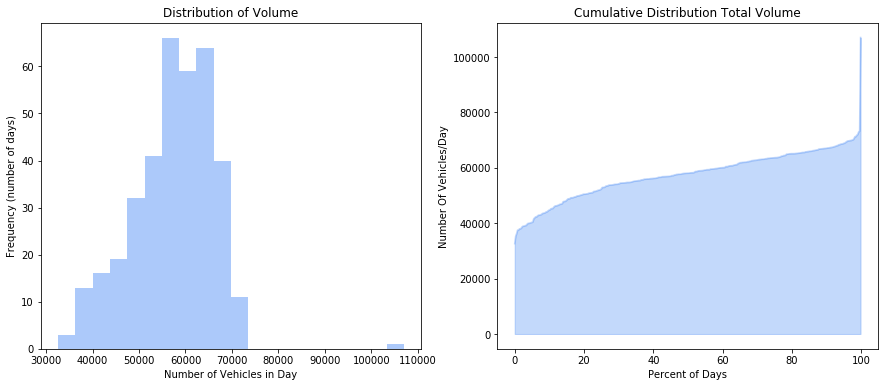

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(sort_all['total_pass'],bins=20,color='#4286f470')
plt.title("Distribution of Volume")
plt.xlabel("Number of Vehicles in Day")
plt.ylabel("Frequency (number of days)")

plt.subplot(1, 2, 2)
sort_all.reset_index(inplace=True, drop=True)
sort_all['percentile'] = np.round(100*sort_all.index.values/sort_all.shape[0],3)
plt.plot(sort_all['percentile'],sort_all['total_pass'],color='#4286f450')
plt.fill_between(sort_all['percentile'],sort_all['total_pass'],color='#4286f450')
plt.title("Cumulative Distribution Total Volume")
plt.xlabel("Percent of Days")
plt.ylabel("Number Of Vehicles/Day")
plt.show()

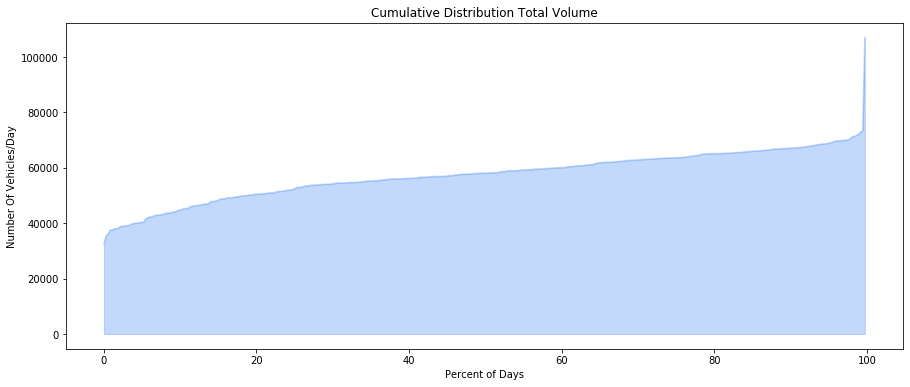

In [15]:
plt.figure(figsize=(15,6))
sort_all.reset_index(inplace=True, drop=True)

sort_all['percentile'] = np.round(100*sort_all.index.values/sort_all.shape[0],3)
plt.plot(sort_all['percentile'],sort_all['total_pass'],color='#4286f450')
plt.fill_between(sort_all['percentile'],sort_all['total_pass'],color='#4286f450')
plt.title("Cumulative Distribution Total Volume")
plt.xlabel("Percent of Days")
plt.ylabel("Number Of Vehicles/Day")
plt.show()

In [16]:
day_df.head()

,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass
date,,,,,,,,,,,,
2017-10-01,7552.0,3034.0,13569,7456,15100,6953,879,480,48,96816,288,54543.0
2017-10-02,13946.0,4682.0,13491,7591,15205,7133,926,480,96,96816,0,62974.0
2017-10-03,11934.0,5074.0,11198,6404,12541,5940,756,480,144,96816,48,53847.0
2017-10-04,11566.0,5585.0,11911,6723,13395,6357,796,480,192,96816,96,56333.0
2017-10-05,11898.0,5086.0,14294,7967,15878,7402,936,480,240,96816,144,63461.0


# Showing all data

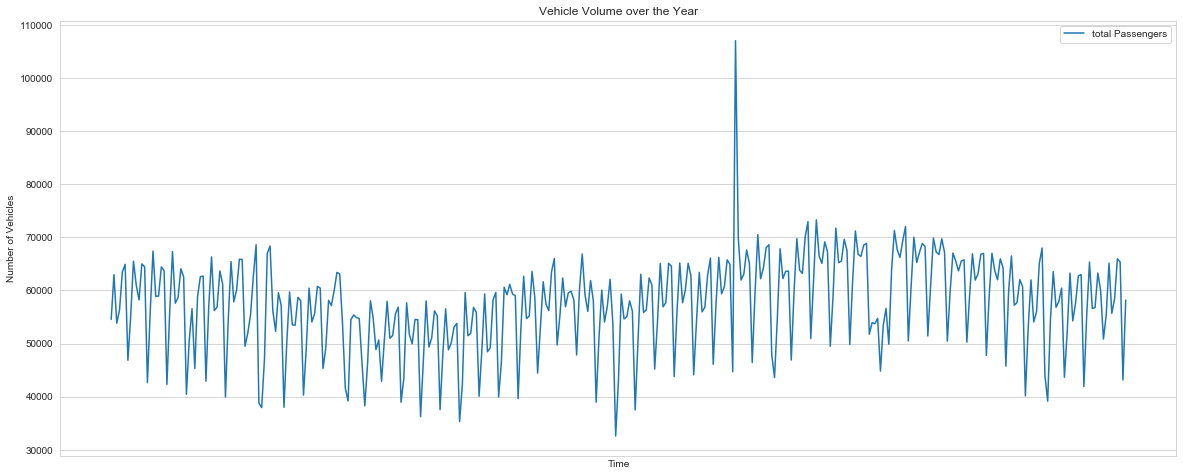

In [17]:
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")

plt.plot(day_df.index,day_df['total_pass'],label='total Passengers')
plt.xticks(rotation=45)
plt.xticks([])
plt.legend()
plt.title("Vehicle Volume over the Year")
plt.xlabel("Time")
plt.ylabel("Number of Vehicles")
plt.show()

# Looking for highest and lowest volume by Day of the week

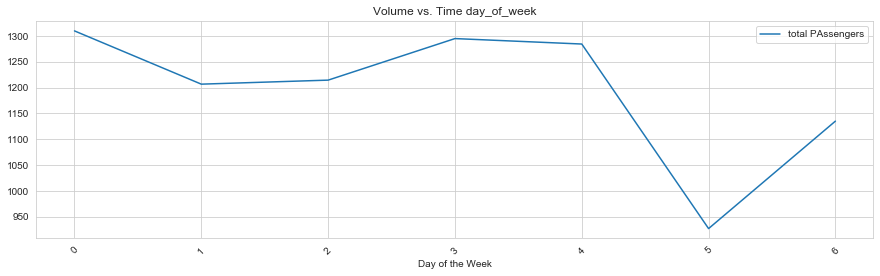

In [18]:
col = 'day_of_week'
agg_dow = demand.groupby(col).mean()
plt.figure(figsize=(15,4))
sns.set_style("whitegrid")

plt.plot(agg_dow.index,agg_dow['total_pass'],label='total PAssengers')
plt.xticks(rotation=45)
plt.title("Volume vs. Time {}".format(col))
plt.xlabel("Day of the Week")
plt.legend()
plt.show()

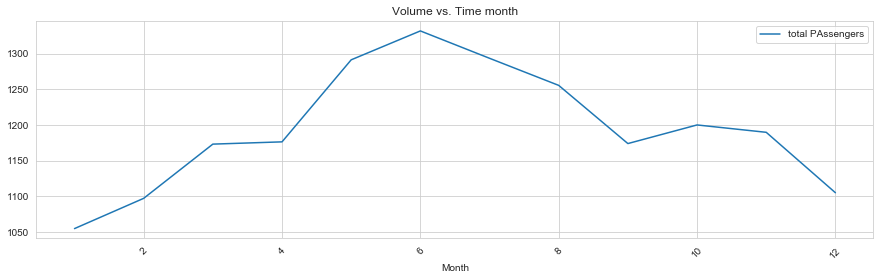

In [19]:
col = 'month'
agg_dow = demand.groupby(col).mean()
plt.figure(figsize=(15,4))
sns.set_style("whitegrid")

plt.plot(agg_dow.index,agg_dow['total_pass'],label='total PAssengers')
plt.xticks(rotation=45)
plt.title("Volume vs. Time {}".format(col))
plt.xlabel("Month")
plt.legend()
plt.show()

In [21]:
def avg_day_month(d,m):
    d = day(d)
    m = month(m)
    agg = demand.loc[(demand['month'] == m) & (demand['day_of_week'] == d)]
    agg = agg.groupby('time').mean()
    return agg

In [22]:
def top_day_month(d,m,p):
    d = day(d)
    m = month(m)
    agg = demand.loc[(demand['month'] == m) & (demand['day_of_week'] == d)]
    agg = agg.groupby('time').quantile(q=p)
    return agg

d = "Monday"
m = "June"
df = top_day_month(d,m,.95)
df.head(10)

0.95,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass
time,,,,,,,,,,,,
00:00:00,15.95,29.55,169.70,97.40,189.75,105.85,11.00,6.0,23.95,2018.0,0.0,601.85
00:30:00,13.25,22.55,154.60,79.30,178.20,78.70,8.85,6.0,23.95,2018.0,0.0,530.50
01:00:00,19.10,20.25,94.20,52.10,113.15,62.60,6.70,6.0,23.95,2018.0,0.0,357.90
01:30:00,9.85,21.55,76.25,42.60,88.75,39.10,4.70,6.0,23.95,2018.0,0.0,280.30
02:00:00,18.00,13.70,54.10,32.45,63.75,28.60,3.70,6.0,23.95,2018.0,0.0,211.55
02:30:00,50.65,22.70,43.25,21.85,48.70,22.70,3.00,6.0,23.95,2018.0,0.0,203.00
03:00:00,112.80,24.55,59.25,32.40,62.55,30.10,3.85,6.0,23.95,2018.0,0.0,320.70
03:30:00,243.65,36.10,112.55,66.95,121.55,59.80,7.00,6.0,23.95,2018.0,0.0,616.20
04:00:00,363.50,30.95,168.95,92.70,183.80,109.00,10.85,6.0,23.95,2018.0,0.0,933.40


# Pick your day of Interest

In [23]:
def pick_day(date):
    day = demand.loc[(demand['date'] == date)]
    day.set_index('time',inplace=True)
    return day, date
day, date = pick_day('2017-12-31')
day.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass,date
time,,,,,,,,,,,,,,
00:00:00,2017-12-31 00:00:00,13.0,18.0,108,54,104,49,6,12,31,2017,6,352.0,2017-12-31
00:30:00,2017-12-31 00:30:00,13.0,15.0,77,48,98,42,5,12,31,2017,6,298.0,2017-12-31
01:00:00,2017-12-31 01:00:00,7.0,12.0,71,39,70,35,4,12,31,2017,6,238.0,2017-12-31
01:30:00,2017-12-31 01:30:00,6.0,10.0,33,18,35,16,2,12,31,2017,6,120.0,2017-12-31
02:00:00,2017-12-31 02:00:00,19.0,9.0,23,13,25,12,2,12,31,2017,6,103.0,2017-12-31


* May 13th, 2018 was the highest volume day form the data we recieved
* Choose another day of interest from above to study or generate demand

# Plotting the Volume by terminal over time

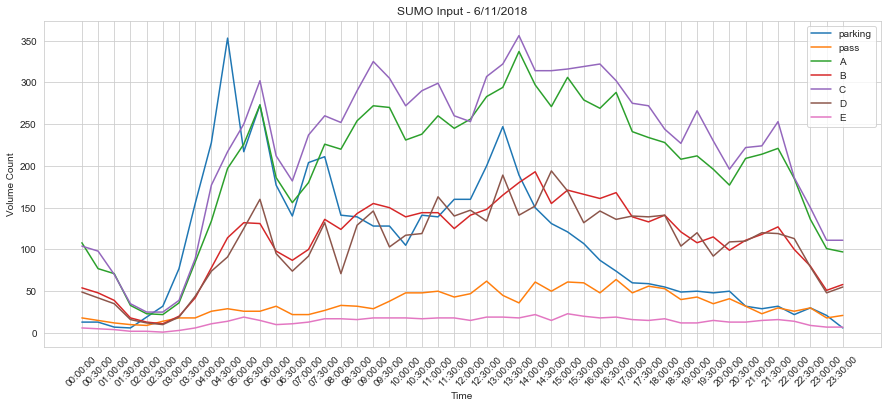

In [24]:
def plot_vol_by_type(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(15,6))

    sns.set_style("whitegrid")
    cols = ['parking','pass','A','B','C','D','E']


    for c in cols:
        plt.plot(df.index,df[c],label=c)
#     plt.axvspan(df.index[8],df.index[11], alpha=0.5, color='#d8d8d8',label="Observed Time in SUMO")


    plt.xticks(rotation=45)
    plt.title("SUMO Input - 6/11/2018")
    plt.legend(loc='upper right')
    plt.xlabel("Time")
    plt.ylabel("Volume Count")
    plt.grid(True)
    plt.show()
plot_vol_by_type(day)

In [25]:
day['terminal_tot'] =  day[['A','B','C','D','E']].sum(axis=1)
day.head()

/Users/jseverin/anaconda3/envs/athena/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,scheduled_fight_time,parking,pass,A,B,C,D,E,month,day,year,day_of_week,total_pass,date,terminal_tot
time,,,,,,,,,,,,,,,
00:00:00,2017-12-31 00:00:00,13.0,18.0,108,54,104,49,6,12,31,2017,6,352.0,2017-12-31,321
00:30:00,2017-12-31 00:30:00,13.0,15.0,77,48,98,42,5,12,31,2017,6,298.0,2017-12-31,270
01:00:00,2017-12-31 01:00:00,7.0,12.0,71,39,70,35,4,12,31,2017,6,238.0,2017-12-31,219
01:30:00,2017-12-31 01:30:00,6.0,10.0,33,18,35,16,2,12,31,2017,6,120.0,2017-12-31,104
02:00:00,2017-12-31 02:00:00,19.0,9.0,23,13,25,12,2,12,31,2017,6,103.0,2017-12-31,75


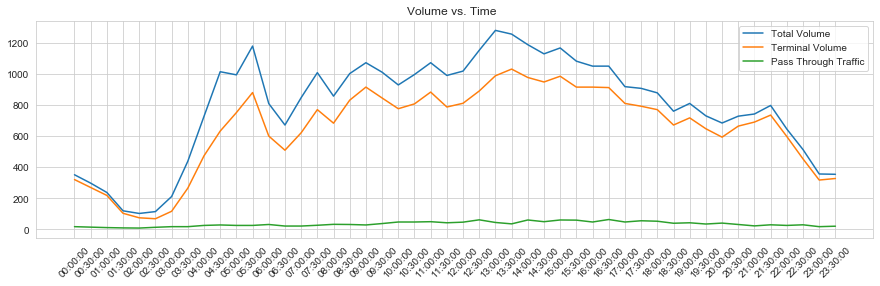

In [26]:
def plot_tot_vs_term(df):
    import matplotlib.pyplot as plt
    import seaborn as sns



    plt.figure(figsize=(15,4))

    sns.set_style("whitegrid")
    plt.plot(df.index,df['total_pass'],label="Total Volume")
    plt.plot(df.index,df['terminal_tot'],label="Terminal Volume")
    plt.plot(df.index,df['pass'],label="Pass Through Traffic")
#     plt.axvspan(df.index[32],df.index[36], alpha=0.5, color='#d8d8d8',label="Observed Time in SUMO")


    plt.xticks(rotation=45)
    plt.title("Volume vs. Time  ")
    plt.legend(loc='upper right')
    plt.show()
    
plot_tot_vs_term(day)

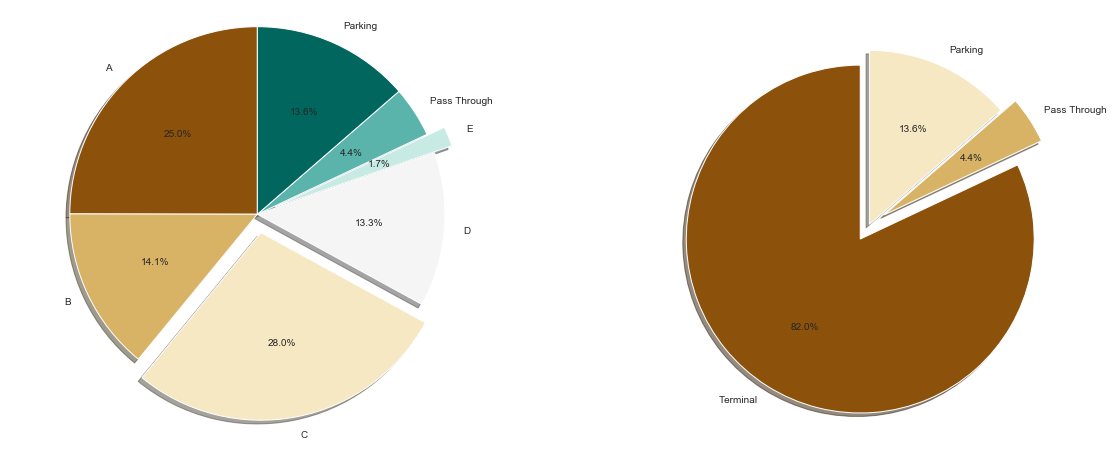

In [28]:
def plot_pie_all(df):
    plt.figure(figsize=(20,8))
    
    labels = ['A','B','C','D','E','Pass Through','Parking']
    inter_labels = ['A','B','C','D','E','pass','parking']
    
    broad = [day['terminal_tot'].sum(axis=0),day['pass'].sum(axis=0),day['parking'].sum(axis=0)]
    broad_label = ['Terminal','Pass Through','Parking']
    explode_broad = np.zeros(3)
    explode_broad[np.argmax(broad,axis=0)] = .1
    explode_broad[np.argmin(broad,axis=0)] = .1
    
    sizes = []
    colors = ['#8c510a','#d8b365','#f6e8c3','#f5f5f5','#c7eae5','#5ab4ac','#01665e']
    for i in inter_labels:
        sizes.append(df[i].sum(axis=0))

    explode = np.zeros(len(sizes))  # only "explode" the 2nd slice (i.e. 'Hogs')
    explode[np.argmax(sizes,axis = 0)] = .1
    explode[np.argmin(sizes,axis = 0)] = .1
    plt.subplot(1, 2, 1)
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.subplot(1, 2, 2)
    plt.pie(broad, explode=explode_broad, labels=broad_label, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    plt.show()
plot_pie_all(day)

## Number of vehicles on this day:

In [30]:
day['total_pass'].sum()

38289.0

In [31]:
terminal_dict = {
    "A":['A_top_1','A_top_2','A_top_3','A_bot_1','A_bot_2','A_bot_3'],
    "B":['B_top_1','B_top_2','B_top_3','B_bot_1','B_bot_2','B_bot_3'],
    "C":['C_top_1','C_top_2','C_top_3','C_bot_1','C_bot_2','C_bot_3'],
    "D":['D_depart_1','D_depart_2','D_arrive_1','D_arrive_2','D_service'],
    "E":['E_top_1','E_top_2','E_top_3','E_bot_1','E_bot_2','E_bot_3'],
    "parking":['park_south_term_1','park_south_term_2','park_south_term_3','park_south_term_4',
              'park_south_emp_1','park_south_emp_2','park_south_emp_3','park_north_emp_1',
              'park_north_emp_2','park_north_emp_3','park_north_emp_4','park_north_emp_5',
              'park_north_emp_6'],
    "pass":"pass_through"
}
stop_dict = {
        "A":['A_top_1','A_top_2','A_top_3','A_bot_1','A_bot_2','A_bot_3'],
        "B":['B_top_1','B_top_2','B_top_3','B_bot_1','B_bot_2','B_bot_3'],
        "C":['C_top_1','C_top_2','C_top_3','C_bot_1','C_bot_2','C_bot_3'],
        "D":['D_depart_1','D_depart_2','D_arrive_1','D_arrive_2','D_service'],
        "E":['E_top_1','E_top_2','E_top_3','E_bot_1','E_bot_2','E_bot_3'],
        "others":['park_south_term_1','park_south_term_2','park_south_term_3','park_south_term_4',
              'park_south_emp_1','park_south_emp_2','park_south_emp_3','park_north_emp_1',
              'park_north_emp_2','park_north_emp_3','park_north_emp_4','park_north_emp_5',
              'park_north_emp_6']
}

In [32]:
def convert_num_2_terminal(num):
    term_dict = {0:"A",1:"B",2:"C",3:"D",4:"E"}
    return term_dict[num]


In [33]:
def model_to_sumo(df,date,policy = True,obey=.5):
    if policy:
        pamt = str(obey*100)
        file_name = 'trip_Policy_' + pamt + "_"+ date+ ".xml"
        print("you chose to impliment the policy!")
    else:
        file_name = 'trip_' + date +  ".xml"
        print('No policy was selected')
    cols = ['parking','pass','A','B','C','D','E']
    pickUpDropOff = [0,0,0,0,0]
    routes_custom = Element('routes')
    routes_custom.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
    routes_custom.set('xsi:noNamespaceSchemaLocation', 'http://sumo.dlr.de/xsd/routes_file.xsd')
    # Additing vehicle type definition for truck and trailer
    park_south = ['park_south_term_1','park_south_term_2','park_south_term_3','park_south_term_4']
    park_north = ['park_north_emp_1',
              'park_north_emp_2','park_north_emp_3','park_north_emp_4','park_north_emp_5',
              'park_north_emp_6']
    terminal_dict = {
        "A":['A_top_1','A_top_2','A_top_3','A_bot_1'], #,'A_bot_2','A_bot_3'],
        "B":['B_top_1','B_top_2','B_top_3','B_bot_1'],#,'B_bot_2','B_bot_3'],
        "C":['C_top_1','C_top_2','C_top_3','C_bot_1'],#,'C_bot_2','C_bot_3'],
        "D":['D_depart_1','D_depart_2','D_arrive_1','D_arrive_2','D_service'],
        "E":['E_top_1','E_top_2','E_top_3','E_bot_1','E_bot_2','E_bot_3'],
        "parking":['park_south_term_1','park_south_term_2','park_south_term_3','park_south_term_4',
                  'park_south_emp_1','park_south_emp_2','park_south_emp_3','park_north_emp_1',
                  'park_north_emp_2','park_north_emp_3','park_north_emp_4','park_north_emp_5',
                  'park_north_emp_6'],
        "pass":"pass_through"
    }
    stop_dict = {
         "A":['A_top_1','A_top_2','A_top_3','A_bot_1'],#,'A_bot_2','A_bot_3'],
        "B":['B_top_1','B_top_2','B_top_3','B_bot_1'],#,'B_bot_2','B_bot_3'],
        "C":['C_top_1','C_top_2','C_top_3','C_bot_1'],#,'C_bot_2','C_bot_3'],
        "D":['D_depart_1','D_depart_2','D_arrive_1','D_arrive_2','D_service'],
        "E":['E_top_1','E_top_2','E_top_3','E_bot_1','E_bot_2','E_bot_3'],
    }
    NorthStart = ['North_Plaza','North_1','North_2']
    SouthStart = ['South_Plaza','South_1','South_2']
    dwell_time = [20,30,40,60,65,70,80,90,100,120,130,140,120,140,150,170,190,200,240,210]
    scaler = 0
    hhr = 60*30
    counter = 0
    for t, time in enumerate(df.index):
        interval = [scaler,(scaler+hhr)]
        scaler+=hhr

        for c in cols:
            vol = int(df.iloc[t][c])
            sample_t = np.around(np.random.uniform(interval[0],interval[1],vol))
            #print(c,terminal_dict[c],vol)
            for s in sample_t:
                counter +=1
                if c == "parking" or c == "pass":
                    boolean = 1
                else:
                    boolean = 0
                if c == "pass":


                    if random.uniform(0, 1) > .45:
                        #coming from the North
                        start = random.choice(NorthStart)
                        if random.uniform(0,1) >.2:
                            #80% of the time they leave the opposite they came
                            end = "South_Exit"
                        else:
                            end = "North_Exit"
                    else:
                        #coming form the South
                        start = random.choice(SouthStart)
                        if random.uniform(0,1) > .2:
                            end = "North_Exit"
                        else:
                            end = "South_Exit"
                elif c == "parking":
                    if random.uniform(0, 1) > .45:
                        #coming from the North
                        start = random.choice(NorthStart)

                    else:
                        #coming form the South
                        start = random.choice(SouthStart)
                    end = random.choice(terminal_dict[c])

                else:


                    if random.uniform(0, 1) > .45:
                        #coming from the North
                        start = random.choice(NorthStart)
                        if random.uniform(0,1) >.2:
                            #80% of the time they leave the same they came
                            end = "North_Exit"
                        else:
                            end = "South_Exit"
                    else:
                        #coming from the South
                        start = random.choice(SouthStart)
                        if random.uniform(0,1) > .2:
                            end = "South_Exit"
                        else:
                            end = "North_Exit"
                    stop = random.choice(stop_dict[c])
                    stop2 = random.choice(stop_dict[c])
                    stop3 = random.choice(stop_dict[c])
                    if policy == True:
                        
                        min_indexN = np.argmin(pickUpDropOff)
                        max_indexN = np.argmax(pickUpDropOff)
                        min_index = convert_num_2_terminal(min_indexN)
                        max_index = convert_num_2_terminal(max_indexN)
                        if c == max_index:
                            if random.uniform(0,1) < obey:
                                if start == "North_Plaza":
                                    if random.uniform(0,1) > .95:
                                        stop = random.choice(park_north)
                                       
                                    else:
                                        stop = random.choice(stop_dict[min_index])

                                else:
                                    if random.uniform(0,1) > .95:
                                        stop = random.choice(park_south)
                                    else:
                                        stop = random.choice(stop_dict[min_index])

                    
                       
                    

                if c == "parking":
                    #print("yellow")
                    color = "0,0,255" #Blue as above in plot
                elif c == "pass":
                    color = "249, 179, 49" # orange
                elif c == "A":
                    color = "16, 135, 40" # green
                    pickUpDropOff[0]+=1
                elif c == "B":
                    color = "216, 2, 16" # red
                    pickUpDropOff[1]+=1
                elif c == "C":
                    color = "124, 85, 135" # purple
                    pickUpDropOff[2]+=1
                elif c == "D":
                    color = "119, 100, 25" # brown
                    pickUpDropOff[3]+=1
                else:
                    color = "255, 130, 171" # pink
                    pickUpDropOff[4]+=1
                r = 1000*round(np.random.uniform(0,1),4)
                trip = Element('trip')
                trip.set('id', (str(counter)+c))
                trip.set('type', 'passenger')
                trip.set('color', color)
                trip.set('depart',str(s))
                trip.set('from',start)
                trip.set('to',end)
                trip.set('departSpeed', "max")
                trip.set('departPos', "last")
                

                routes_custom.append(trip)
                duration = str(random.choice(dwell_time))
                if boolean == 0:
                    ET.SubElement(trip, "stop",busStop=stop,duration=duration,parking='true')
                    
    routes_custom[:] = sorted(routes_custom, key=lambda child: (child.tag,float(child.get('depart'))))



    
    print("Saving to xml: ", file_name)
    configfile = os.path.join(this_folder, file_name)
    with open(configfile, 'wb') as f:
        f.write(minidom.parseString(ET.tostring(routes_custom)).toprettyxml(encoding="utf-8"))



In [40]:
model_to_sumo(day,date,False)

No policy was selected
Saving to xml:  trip_2017-12-31.xml


In [50]:
additional = Element('additional')
additional.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
additional.set('xsi:noNamespaceSchemaLocation', "http://sumo.dlr.de/xsd/additional_file.xsd")
# Additing vehicle type definition for truck and trailer

vtype = Element('vType')
vtype.set('id', 'truck')
vtype.set('vClass', 'truck')
additional.append(vtype)
vtype1 = Element('vType')
vtype1.set('id', 'trailer')
vtype1.set('vClass', 'trailer')
additional.append(vtype1)
vtype2 = Element('vType')
vtype2.set('id', 'passenger')
vtype2.set('vClass', 'passenger')
additional.append(vtype2)
vtype3 = Element('vType')
vtype3.set('id', 'bus')
vtype3.set('vClass', 'bus')
additional.append(vtype3)
for s in stop_dict.keys():
    
    
    for ind in stop_dict[s]:
        
        lane = ind + "_0"
        
        busStop = Element('busStop')
        busStop.set('id', ind)
        busStop.set('lane', lane)
        busStop.set('friendlyPos','1')
        busStop.set('lines','1')
        busStop.set('startPos','0')
        busStop.set('endPos','-1')
        

        additional.append(busStop)
file_name = 'additional_' + date + ".xml"
print("Saving to xml: ", file_name)
configfile = os.path.join(this_folder, file_name)
with open(configfile, 'wb') as f:
    f.write(minidom.parseString(ET.tostring(additional)).toprettyxml(encoding="utf-8"))
    

Saving to xml:  additional_2018-05-13.xml
